# Statistical Methodological Comparison Notebook
The point of this notebook is to walk the user through a numpyro-based comparitive analysis of a hierarchical model and two non-hierarchical models (full pooling and unpooled).

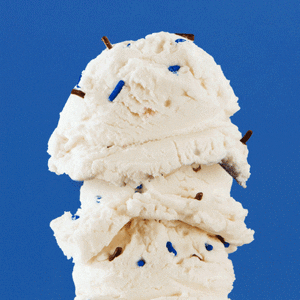

Hierarchical models are like ice cream; each layer of stack mixes with the other layers, lending them inference power. This notebook steps out to demonstrate empirically that hierarchical models are more powerful and here we carry out a careful treatment of the uncertainty quantification.

## The dataset: simple pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [7]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [10]:
## plotting and analysis utilities

def display_pendulum_data(df):
    ## plot all pendulums and pendulums color-coded by planet
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7',
                  '#FFB7C3', '#2F2F2F', '#4A4063', '#FE5E41']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.title('pendulums color-coded by planet')
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    ## plot the prior predictive histograms for parameters in the model
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )
    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

def pos_calculator(L, theta, a_g, sigma, time):
    ## because the sampler chain doesn't save the position at each point in time,
    ## i have created a thing that samples position for us
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length):
    ## print out the mean and standard deviation on the posterior parameters for
    ## each individual pendulum and make multiple draws from the posterior distribution
    ## to plot "theoretical" pendulum trajectories
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            try:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            except IndexError: # for the unpooled case
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')
        plt.show()

def how_did_we_do_on_all_pendulums(df, posterior, n_pendulums, chain_length):
    ## plot the 3 sigma position intervals from these posteriors for all pendulums at once
    ## (should probably redo this to more cleanly see each pendulum individually)
    n_pendulums = 8
    chain_length = 2000
    # first do the first four pendulums
    # hots
    colors = ['#F26419', '#F6AE2D', '#820263', '#D90368']
    plt.clf()
    for number in range(4):
        sub_df = df[df['pend_code'] == number]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            try:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            except IndexError: # for the unpooled case
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(L,theta,a_g,sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average - 3 * y_std, y_average + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = colors[number])
    plt.title('Pendulums on planet 1')
    plt.show()

    # second four pendulums (from planet 2) are cool colors
    colors = ['#33658A', '#86BBD8', '#2F4858', '#6CC551']
    plt.clf()
    for number in range(4):
        number_2 = number + 3
        sub_df = df[df['pend_code'] == number_2]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number_2]
            theta = posterior['theta'][j,number_2]
            try:
                a_g = posterior['a_g'][j,number_2]#
            except IndexError:
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(L,theta,a_g,sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average - 3 * y_std, y_average + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = colors[number])
    plt.title('Pendulums on planet 2')
    plt.show()


## Hierarchical model
Again, this is the full ice cream stack model. Here, there are global values (μ_a_g and σ_a_g), from which the individual a_g values are drawn for each planet. The a_g values get information from all pendulums on a given planet AND from the global values which also are informed by the pendulums on the other planet. The L and theta are sampled for each individual planet.

Note that there is an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.

In [11]:
def hierarchical_model(planet_code, pendulum_code, times, pos_obs=None):
    ## inputs to a numpyro model are rows from a dataframe:
    ## planet code - array of embedded numbers representing which planet {0...1}
    ## pendulum code - array of embedded numbers representing which pendulum {0...7}
    ## times - moments in time (s)
    ## pos_obs - this is optional, set to None but used to compare the model with data
    ## (when data, xpos, is defined)
    
    ## numpyro models function by drawing parameters from samples 
    ## first, we define the global parameters, mean and sigma of a normal from
    ## which the individual a_g values of each planet will be drawn
    

    μ_a_g = numpyro.sample("μ_a_g", dist.Uniform(1.0,20.0))
    σ_a_g = numpyro.sample("σ_a_g", dist.Uniform(0.0,5))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    ## plates are a numpyro primitive or context manager for handing conditionally independence
    ## for instance, we wish to model a_g for each planet independently
    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Normal(μ_a_g, σ_a_g))
    
    ## we also wish to model L and theta for each pendulum independently
    ## here we draw from an uniform distribution
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    ## σ is the error on the position measurement for each moment in time
    ## we also model this
    ## eventually, we should also model the error on each parameter independently?
    ## draw from an exponential distribution parameterized by a rate parameter
    ## the mean of an exponential distribution is 1/r where r is the rate parameter
    ## exponential distributions are never negative. This is good for error.
    σ = numpyro.sample("σ", dist.Exponential(2))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    
    ## the moments in time are not independent, so we do not place the following in a plate
    ## instead, the brackets segment the model by pendulum and by planet,
    ## telling us how to conduct the inference
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code]) * times))
    ## don't forget to use jnp instead of np so jax knows what to do
    ## A BIG QUESTION I STILL HAVE IS WHAT IS THE LIKELIHOOD? IS IT JUST SAMPLED FROM?
    
    ## again, for each pendulum we compare the observed to the modeled position:
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Now non-hierarchical setup
There are two types of non-hierarchical setups, one is full pooling (where the a_g value is drawn once overall), and one is no pooling (where the a_g value is sampled for each planet individually without any uniting global variables).

The (fully) pooled model (from here on, just `pooled') is like soft serve.

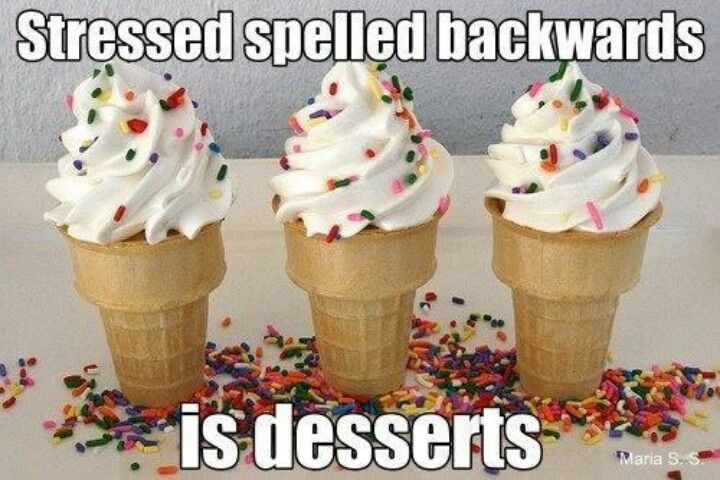

This is because it mixes all data together in the goal of producing one estimate. A lot of information is lost, making it harder to predict individual cases. Let's say we know that a pendulum is on planet one. That lends us no extra information compared to being agnostic about the position.

In [12]:
def pooled_model(pendulum_code, times, pos_obs=None):
    ## a_g is estimated globally in this model
    ## and the only plates are over the different pendulums, as before
    
    n_pendulums = len(np.unique(pendulum_code))
    a_g = numpyro.sample("a_g", dist.Uniform(5, 20))
    
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g / L[pendulum_code]) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

The unpooled model is like a bunch of different ice cream cones:

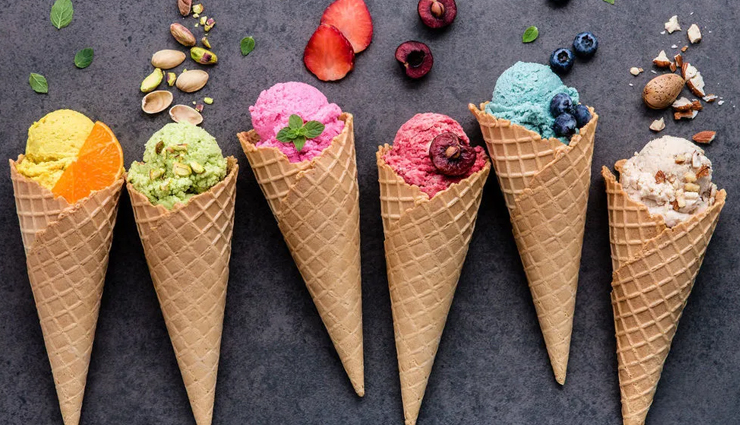

Here, the modeling is fully segmented for each planet (here, ice cream cone). This means the model has no mechanism (such as a global distribution characterized by μ_a_g and σ_a_g) to share information between groups.

In [13]:
def unpooled_model(planet_code, pendulum_code, times, pos_obs=None):
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))
    
    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Uniform(5,20))#dist.Normal(10, 2))

    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))#dist.HalfNormal(2.0))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code]) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [14]:
data_params = {
    'length': [10, 15, 13, 12,
               9, 7, 11, 12],
    'theta': [jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4,
              jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4],
    'a_g': [14, 14, 14, 14, 
            15, 15, 15, 15],
    'pos_err': [0.05, 0.05, 0.05, 0.05,
                0.05, 0.05, 0.05, 0.05],
    'planet_id': [int(0), int(0), int(0), int(0),
                  int(1), int(1), int(1), int(1)]
    
}

## create the DataFrame
df = pd.DataFrame(data_params)

## regenerate each pendulum for multiple moments in time
times = np.linspace(0,10,50) # seconds

## repeat each row in the DataFrame based on the length of the new list
replicated_df = pd.DataFrame(np.repeat(df.values, len(times), axis=0), columns=df.columns)

## create the new column with values from the new list
replicated_df['time'] = np.tile(times, len(df))
## create a new column with numerical IDs for each original row
replicated_df['pendulum_id'] = np.repeat(np.arange(len(df)), len(times))

df = replicated_df
## generate the position
## there is a little bit of random noise here, generated from a random normal multiplied by pos_err
df['pos'] = df['length'] * np.sin(df['theta'] * np.cos(np.sqrt(df['a_g'] / df['length']) * df['time'])) + df['pos_err'] * np.random.randn(len(df['time']))

## encode the pendulum_id and planet_id columns into code columns
pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pendulum_id"].values

df

length     theta   a_g  pos_err  planet_id       time  pendulum_id  \
0      10.0  0.785398  14.0     0.05        0.0   0.000000            0   
1      10.0  0.785398  14.0     0.05        0.0   0.204082            0   
2      10.0  0.785398  14.0     0.05        0.0   0.408163            0   
3      10.0  0.785398  14.0     0.05        0.0   0.612245            0   
4      10.0  0.785398  14.0     0.05        0.0   0.816327            0   
..      ...       ...   ...      ...        ...        ...          ...   
395    12.0  0.785398  15.0     0.05        1.0   9.183673            7   
396    12.0  0.785398  15.0     0.05        1.0   9.387755            7   
397    12.0  0.785398  15.0     0.05        1.0   9.591837            7   
398    12.0  0.785398  15.0     0.05        1.0   9.795918            7   
399    12.0  0.785398  15.0     0.05        1.0  10.000000            7   

          pos  pend_code  planet_code  
0    7.109191          0            0  
1    6.936603          0            0  
2    6.468233          0            0  
3    5.494988          0            0  
4    4.355560          0            0  
..        ...        ...          ...  
395 -5.983781          7            1  
396 -4.316770          7            1  
397 -2.588382          7            1  
398 -0.458674          7            1  
399  1.721458          7            1  

[400 rows x 10 columns]

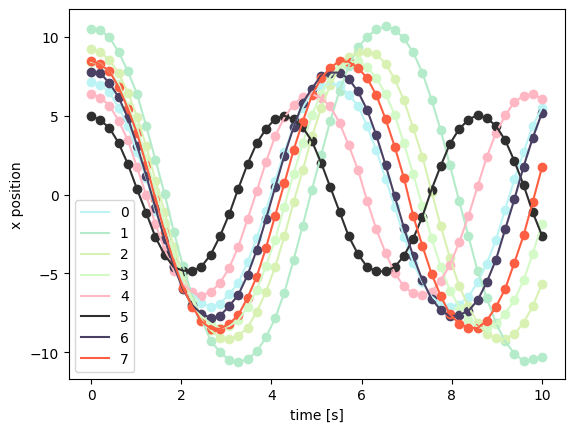

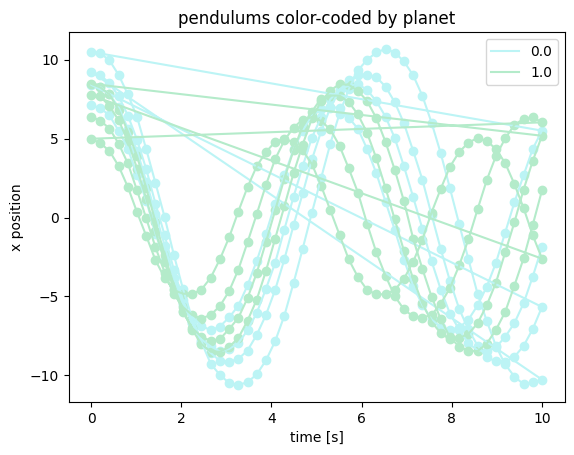

In [15]:
## take a look at the path of the eight pendulums
display_pendulum_data(df)

## Visualize the probabilistic graph
Numpyro has some neat tools for creating DAGS - directive acyclic graphs

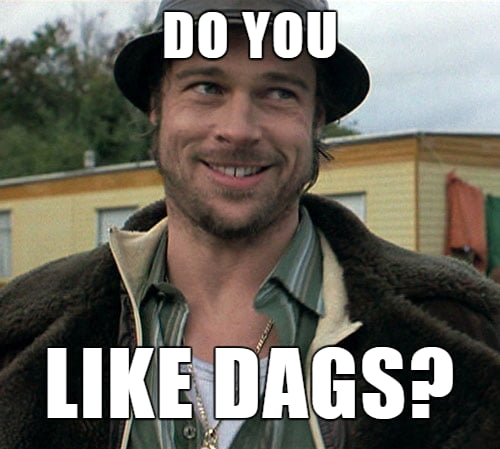

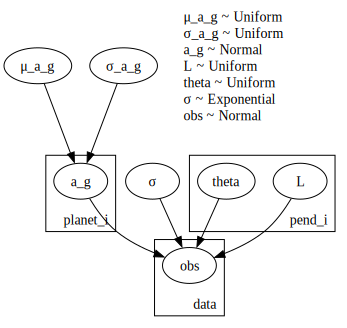

In [16]:
## first hierarchical
numpyro.render_model(
    model=hierarchical_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

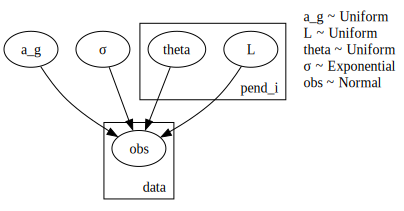

In [19]:
## full pooled
numpyro.render_model(
    model=pooled_model,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

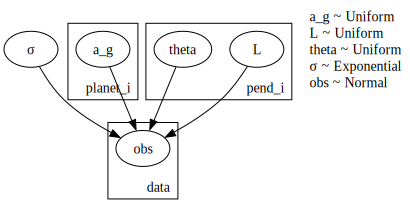

In [20]:
## unpooled
numpyro.render_model(
    model=unpooled_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

## Prior predictive distribution
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.

(400,) (400,) (50,)


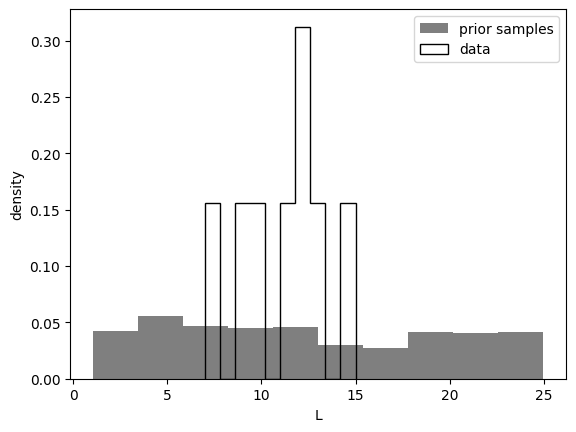

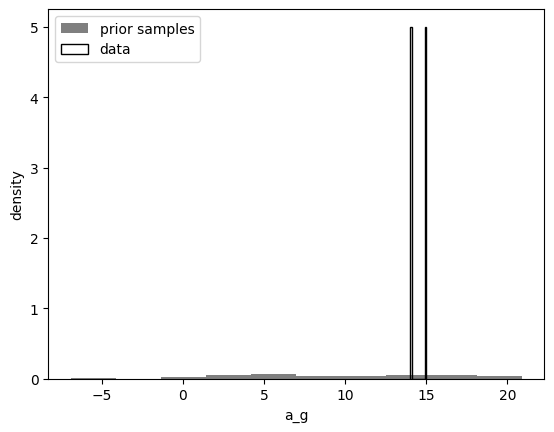

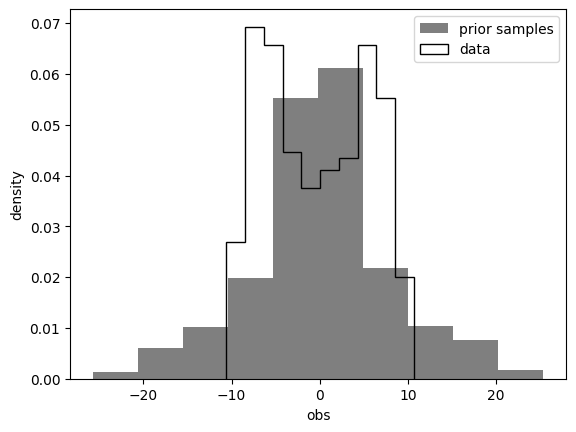

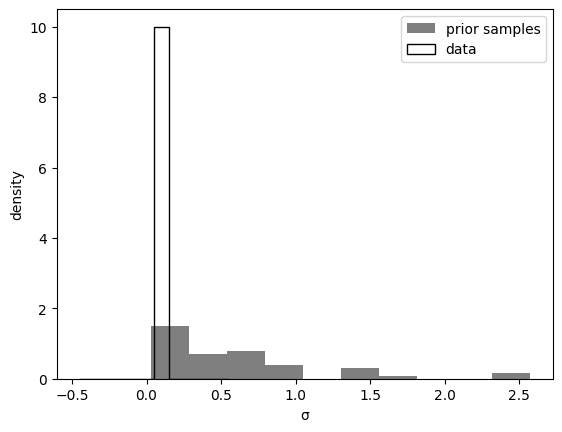

In [21]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

print(np.shape(planet_code), np.shape(pend_code), np.shape(times))
prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)

Pendulum number 0
true L = 10.0
posterior L = 12.289999961853027 +/- 7.279999732971191
true theta = 0.7853981633974482
posterior theta = 0.7900000214576721 +/- 0.4399999976158142
true a_g = 14.0
posterior a_g = 9.5 +/- 6.230000019073486


/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_19783/1585631864.py:62: RuntimeWarning: invalid value encountered in sqrt
  pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))


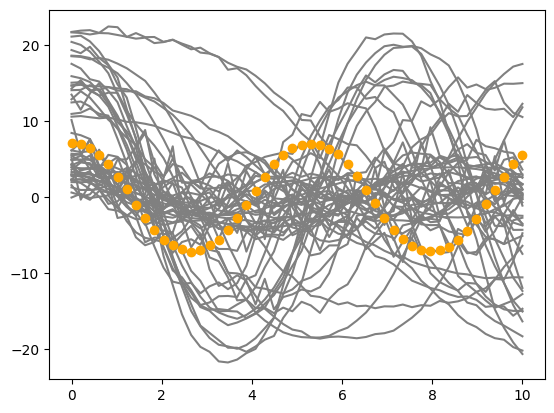

Pendulum number 1
true L = 15.0
posterior L = 10.3100004196167 +/- 6.509999752044678
true theta = 0.7853981633974482
posterior theta = 1.0399999618530273 +/- 0.47999998927116394
true a_g = 14.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


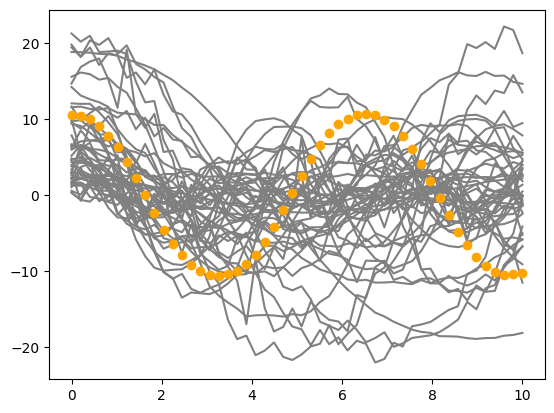

Pendulum number 2
true L = 13.0
posterior L = 12.630000114440918 +/- 6.829999923706055
true theta = 0.7853981633974482
posterior theta = 0.8700000047683716 +/- 0.47999998927116394
true a_g = 14.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


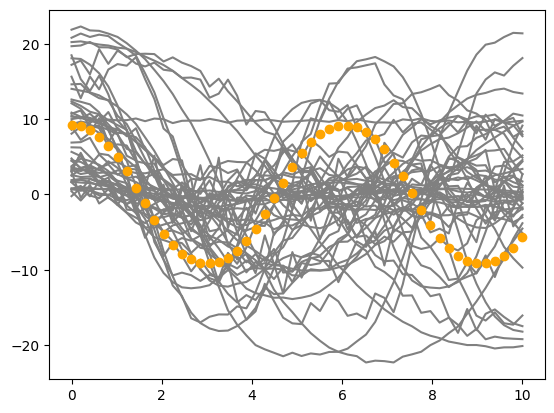

Pendulum number 3
true L = 12.0
posterior L = 15.319999694824219 +/- 6.949999809265137
true theta = 0.7853981633974482
posterior theta = 0.699999988079071 +/- 0.4399999976158142
true a_g = 14.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


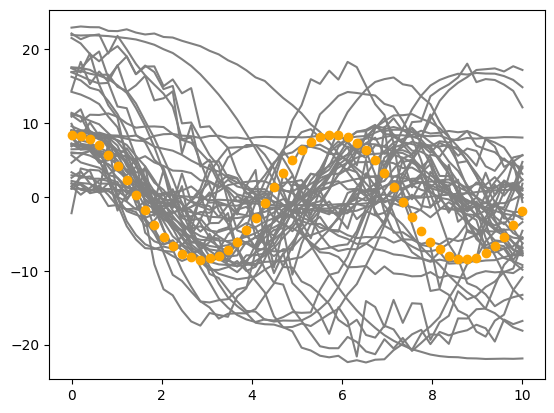

Pendulum number 4
true L = 9.0
posterior L = 10.880000114440918 +/- 6.899999618530273
true theta = 0.7853981633974482
posterior theta = 0.8500000238418579 +/- 0.44999998807907104
true a_g = 15.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


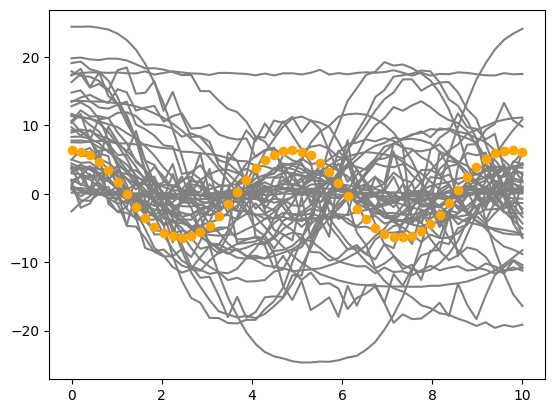

Pendulum number 5
true L = 7.0
posterior L = 12.050000190734863 +/- 6.730000019073486
true theta = 0.7853981633974482
posterior theta = 0.8399999737739563 +/- 0.4599999785423279
true a_g = 15.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


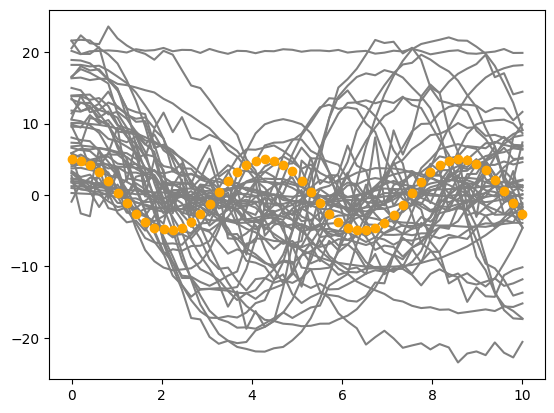

Pendulum number 6
true L = 11.0
posterior L = 10.600000381469727 +/- 7.96999979019165
true theta = 0.7853981633974482
posterior theta = 0.8500000238418579 +/- 0.4099999964237213
true a_g = 15.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


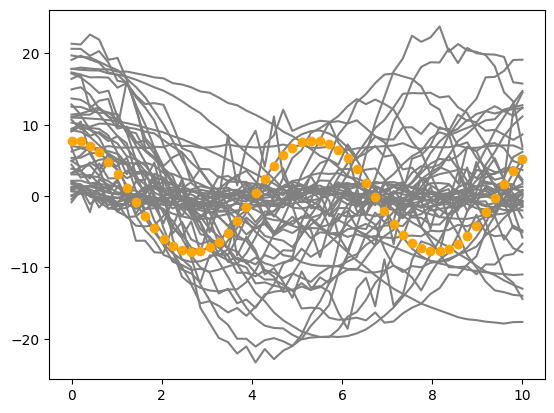

Pendulum number 7
true L = 12.0
posterior L = 9.079999923706055 +/- 7.299999713897705
true theta = 0.7853981633974482
posterior theta = 0.699999988079071 +/- 0.4699999988079071
true a_g = 15.0
posterior a_g = 8.380000114440918 +/- 6.589999675750732


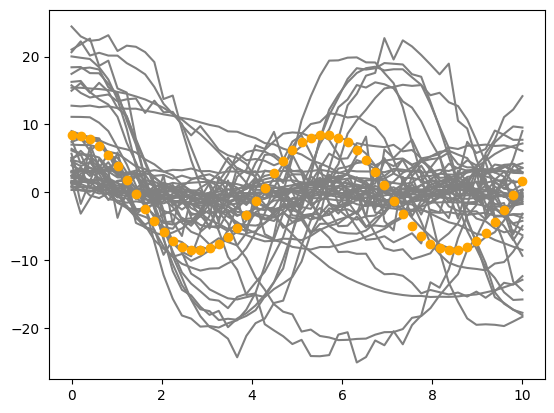

In [22]:
## visualize the trajectories generated by the prior predictive parameters
## when they are run through the simulator
## this function runs for each individual pendulum and compares
## the "posterior" drawn from the pre-inference parameters (flat distributions)
## to the true values in the observed dataframe
## we're expecting these error terms to be large pre-inference
how_did_we_do_on_individual_pendulums(df, prior_pred, 8, 50)


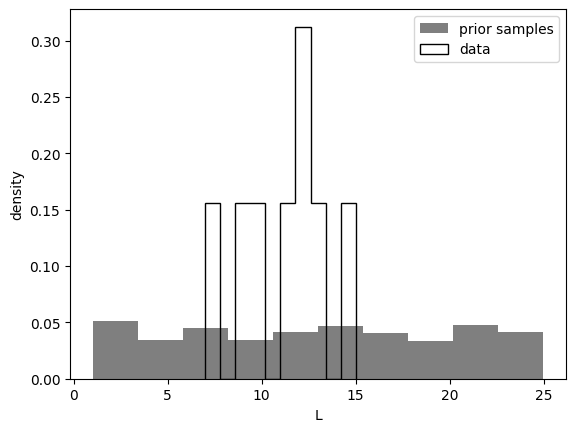

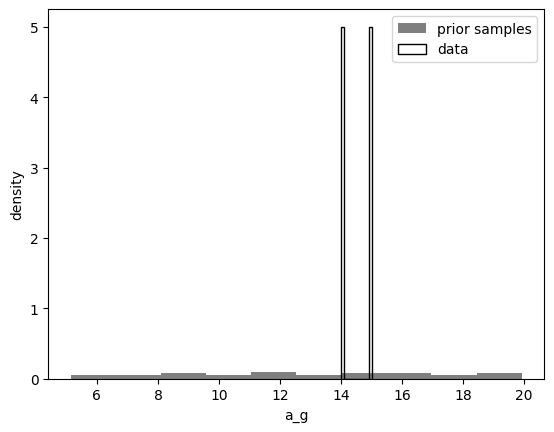

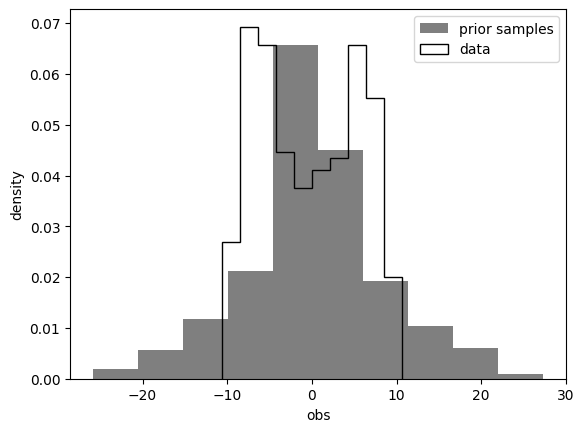

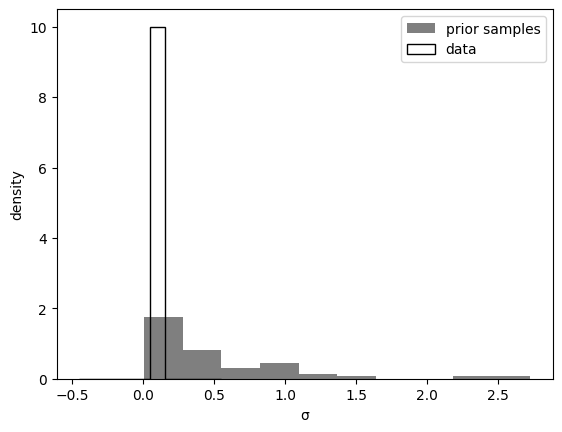

In [23]:
## same but for the unpooled model
prior_pred_unpooled = numpyro.infer.Predictive(unpooled_model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

plot_prior_predictive(prior_pred_unpooled, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred_unpooled, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred_unpooled, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred_unpooled, "σ", "pos_err", n_steps=10, title = None)

Pendulum number 0
true L = 10.0
posterior L = 11.390000343322754 +/- 6.819999694824219
true theta = 0.7853981633974482
posterior theta = 0.5699999928474426 +/- 0.429999977350235
true a_g = 14.0
posterior a_g = 12.380000114440918 +/- 4.049999713897705


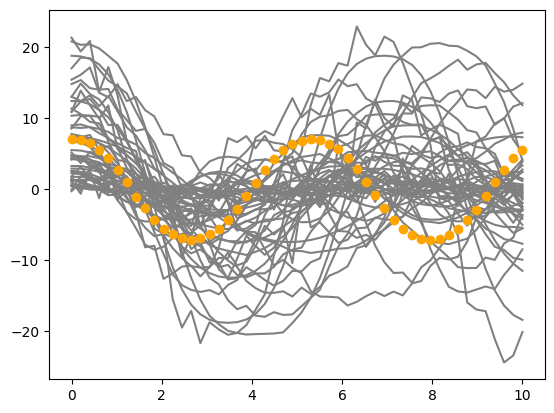

Pendulum number 1
true L = 15.0
posterior L = 10.489999771118164 +/- 7.569999694824219
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4399999976158142
true a_g = 14.0
posterior a_g = 14.0 +/- 4.210000038146973


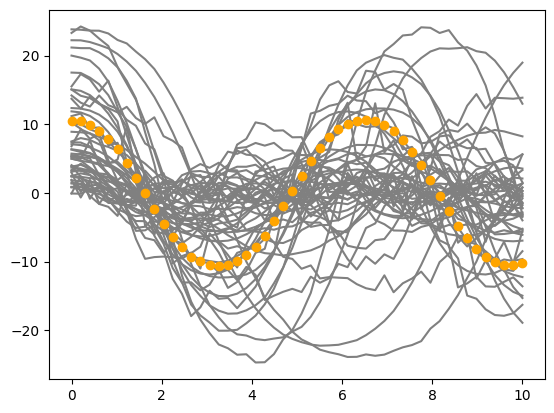

Pendulum number 2
true L = 13.0
posterior L = 14.479999542236328 +/- 7.0
true theta = 0.7853981633974482
posterior theta = 0.6299999952316284 +/- 0.47999998927116394
true a_g = 14.0
posterior a_g = 14.0 +/- 4.210000038146973


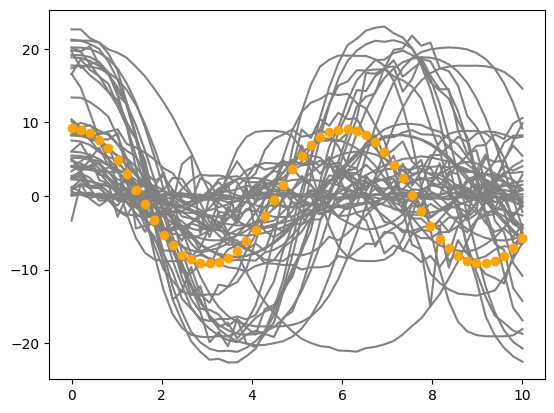

Pendulum number 3
true L = 12.0
posterior L = 11.539999961853027 +/- 6.609999656677246
true theta = 0.7853981633974482
posterior theta = 0.8500000238418579 +/- 0.429999977350235
true a_g = 14.0
posterior a_g = 14.0 +/- 4.210000038146973


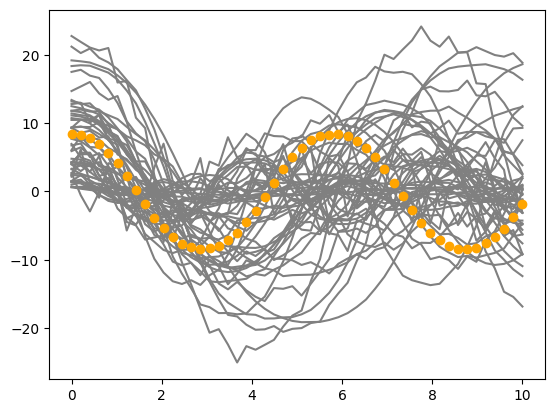

Pendulum number 4
true L = 9.0
posterior L = 14.050000190734863 +/- 7.449999809265137
true theta = 0.7853981633974482
posterior theta = 0.9300000071525574 +/- 0.41999998688697815
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


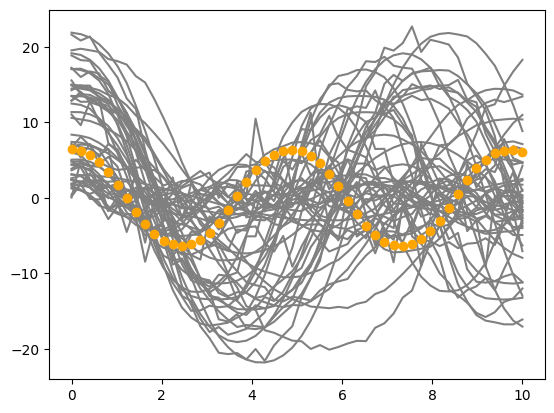

Pendulum number 5
true L = 7.0
posterior L = 13.789999961853027 +/- 7.12999963760376
true theta = 0.7853981633974482
posterior theta = 0.75 +/- 0.4599999785423279
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


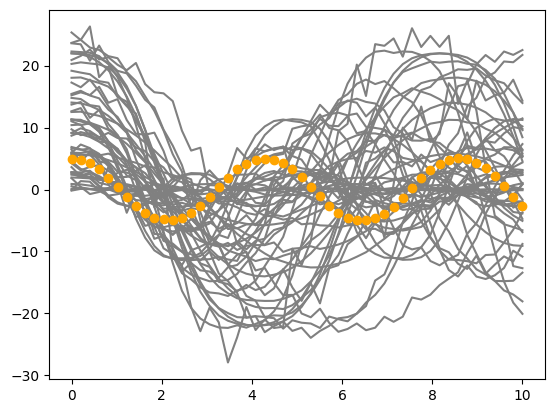

Pendulum number 6
true L = 11.0
posterior L = 13.90999984741211 +/- 6.289999961853027
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4899999797344208
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


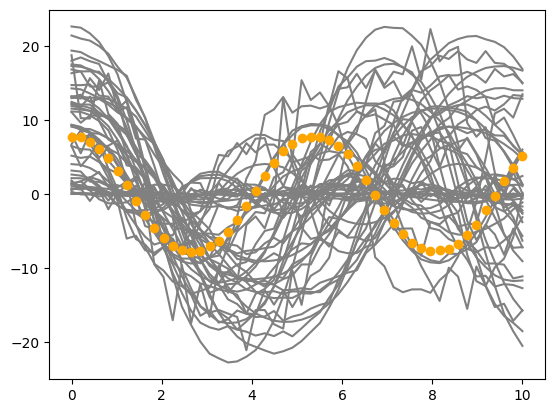

Pendulum number 7
true L = 12.0
posterior L = 12.890000343322754 +/- 6.739999771118164
true theta = 0.7853981633974482
posterior theta = 0.9399999976158142 +/- 0.429999977350235
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


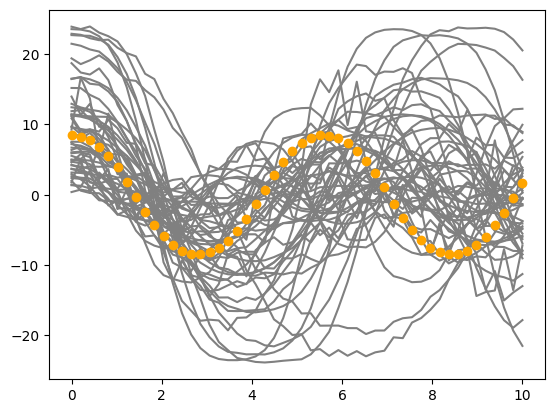

In [24]:
how_did_we_do_on_individual_pendulums(df, prior_pred_unpooled, 8, 50)


## Run the inference for the hierarchical case

In [26]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(hierarchical_model)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples = mcmc.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
## the arviz tools allows us to investigate the chain performance
inf_data = az.from_numpyro(mcmc)
## zero divergence means energy is conserved
print(f'divergences: {inf_data.sample_stats.diverging.values.sum()}')
az.summary(inf_data)

divergences: 0


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]       9.885  0.082   9.737   10.042      0.001    0.001    3103.0   
L[1]      14.819  0.122  14.590   15.047      0.002    0.002    3102.0   
L[2]      12.844  0.106  12.653   13.049      0.002    0.001    3097.0   
L[3]      11.865  0.098  11.680   12.047      0.002    0.001    3101.0   
L[4]       9.073  0.101   8.879    9.261      0.002    0.001    3168.0   
L[5]       7.067  0.079   6.916    7.213      0.001    0.001    3162.0   
L[6]      11.092  0.123  10.855   11.321      0.002    0.002    3163.0   
L[7]      12.105  0.135  11.846   12.357      0.002    0.002    3162.0   
a_g[0]    13.840  0.114  13.626   14.053      0.002    0.001    3097.0   
a_g[1]    15.129  0.168  14.809   15.446      0.003    0.002    3162.0   
theta[0]   0.797  0.008   0.782    0.812      0.000    0.000    3182.0   
theta[1]   0.796  0.008   0.781    0.811      0.000    0.000    3129.0   
theta[2]   0.796  0.008   0.781    0.811      0.000    0.000    3127.0   
theta[3]   0.794  0.008   0.779    0.808      0.000    0.000    3181.0   
theta[4]   0.778  0.010   0.758    0.798      0.000    0.000    3217.0   
theta[5]   0.778  0.010   0.759    0.798      0.000    0.000    3252.0   
theta[6]   0.777  0.010   0.758    0.797      0.000    0.000    3193.0   
theta[7]   0.777  0.010   0.757    0.796      0.000    0.000    3193.0   
μ_a_g     14.418  1.716  10.990   18.102      0.023    0.017    6032.0   
σ          0.052  0.002   0.048    0.055      0.000    0.000    9023.0   
σ_a_g      2.182  1.246   0.385    4.515      0.020    0.015    3940.0   

          ess_tail  r_hat  
L[0]        4344.0    1.0  
L[1]        4384.0    1.0  
L[2]        4396.0    1.0  
L[3]        4358.0    1.0  
L[4]        4038.0    1.0  
L[5]        3981.0    1.0  
L[6]        3914.0    1.0  
L[7]        4008.0    1.0  
a_g[0]      4393.0    1.0  
a_g[1]      3962.0    1.0  
theta[0]    4818.0    1.0  
theta[1]    4481.0    1.0  
theta[2]    4525.0    1.0  
theta[3]    4670.0    1.0  
theta[4]    4053.0    1.0  
theta[5]    4185.0    1.0  
theta[6]    4048.0    1.0  
theta[7]    3981.0    1.0  
μ_a_g       3915.0    1.0  
σ           8358.0    1.0  
σ_a_g       4850.0    1.0

## Interpreting the arviz table
The first two columns are the mean and standard deviation of each parameter, taken from examining all four chains.

- hdi = the high density interval, which is the minimum width Bayesian credible interval (BCI)

The best description I've found for it:

The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. In contrast, a symmetric density interval defined by (eg.) the 10% and 90% quantiles may include values with lower probability than those excluded.


- mcse = markov chain standard error

- ess = effective sample size

This is equal to the sample size if all samples are independent. Here, the values are quite low for the different parameters, which indicates that we have very few indpendent draws. Does this mean we need to length the chains? Maybe.

- rhat = rank normalized splitR-hat for a set of traces (https://arxiv.org/pdf/1903.08008.pdf)

The rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

rhat ~ sqrt(1 + Nchains/ESS), 


so ESS/Nchains ~ 1/2/(rhat - 1), which means that if rhat = 1.05 then ESS/Nchains = 10, which isn’t very big

In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25), legend=True);

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [29]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc.get_samples()['a_g']))

shape of L samples (20000, 8)
shape of a_g samples (20000, 2)


In [30]:
posterior = mcmc.get_samples()
posterior

{'L': Array([[ 9.965286 , 14.929125 , 12.943    , ...,  7.1146126, 11.158162 ,
         12.169662 ],
        [ 9.95152  , 14.911581 , 12.924716 , ...,  7.0973434, 11.144333 ,
         12.166285 ],
        [ 9.913474 , 14.852608 , 12.884594 , ...,  6.9557667, 10.911217 ,
         11.910311 ],
        ...,
        [ 9.990076 , 14.985348 , 12.9779   , ...,  7.163107 , 11.23759  ,
         12.26562  ],
        [ 9.989197 , 14.980797 , 12.981483 , ...,  7.164811 , 11.237051 ,
         12.260035 ],
        [ 9.9837885, 14.962553 , 12.9778805, ...,  7.1641474, 11.231172 ,
         12.268818 ]], dtype=float32),
 'a_g': Array([[13.942924 , 15.221211 ],
        [13.928129 , 15.202157 ],
        [13.875576 , 14.887067 ],
        ...,
        [13.990286 , 15.328324 ],
        [13.989564 , 15.329993 ],
        [13.977757 , 15.3354225]], dtype=float32),
 'theta': Array([[0.78816515, 0.7897144 , 0.78956205, ..., 0.7732854 , 0.7710446 ,
         0.77336234],
        [0.78886837, 0.7909373 , 0.7897969 

Pendulum number 0
true L = 10.0
posterior L = 9.880000114440918 +/- 0.07999999821186066
true theta = 0.7853981633974482
posterior theta = 0.800000011920929 +/- 0.009999999776482582
true a_g = 14.0
posterior a_g = 13.84000015258789 +/- 0.10999999940395355


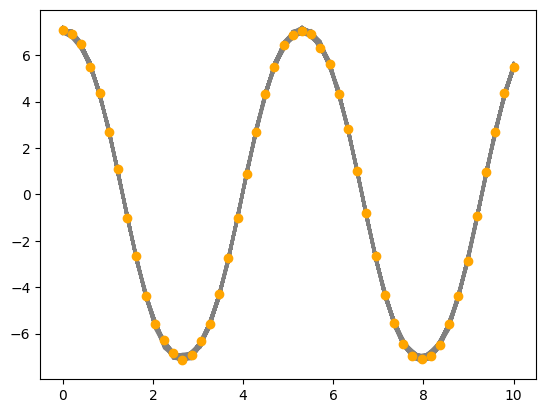

Pendulum number 1
true L = 15.0
posterior L = 14.819999694824219 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.800000011920929 +/- 0.009999999776482582
true a_g = 14.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


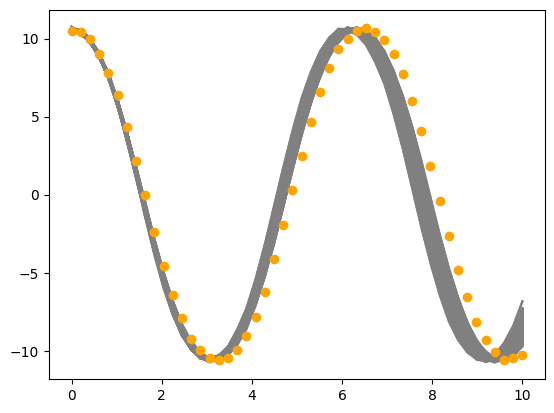

Pendulum number 2
true L = 13.0
posterior L = 12.84000015258789 +/- 0.10999999940395355
true theta = 0.7853981633974482
posterior theta = 0.800000011920929 +/- 0.009999999776482582
true a_g = 14.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


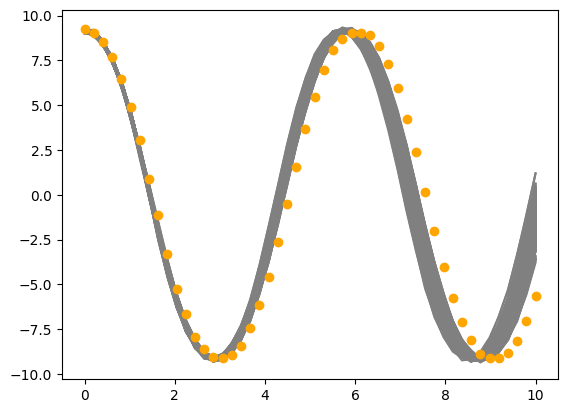

Pendulum number 3
true L = 12.0
posterior L = 11.859999656677246 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7900000214576721 +/- 0.009999999776482582
true a_g = 14.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


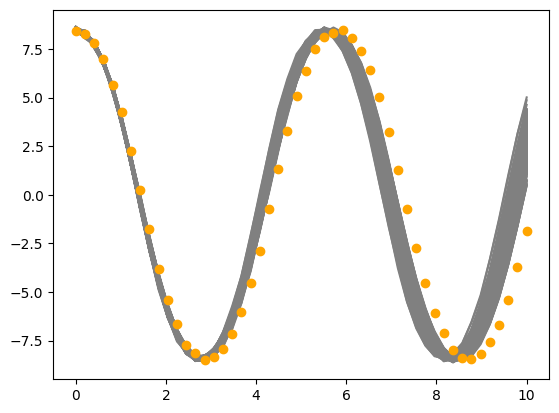

Pendulum number 4
true L = 9.0
posterior L = 9.069999694824219 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


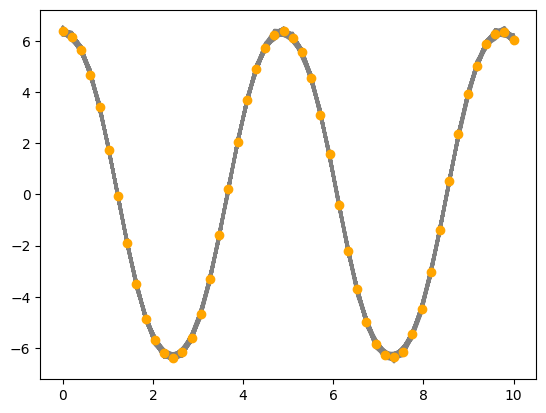

Pendulum number 5
true L = 7.0
posterior L = 7.059999942779541 +/- 0.07999999821186066
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


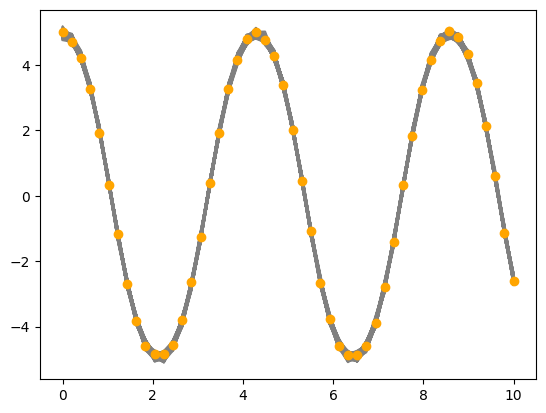

Pendulum number 6
true L = 11.0
posterior L = 11.09000015258789 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


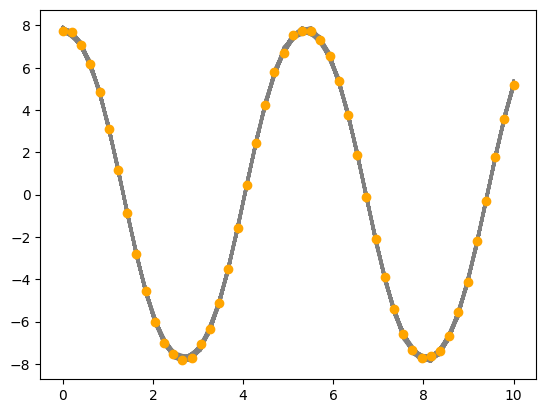

Pendulum number 7
true L = 12.0
posterior L = 12.100000381469727 +/- 0.12999999523162842
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 15.119999885559082 +/- 0.17000000178813934


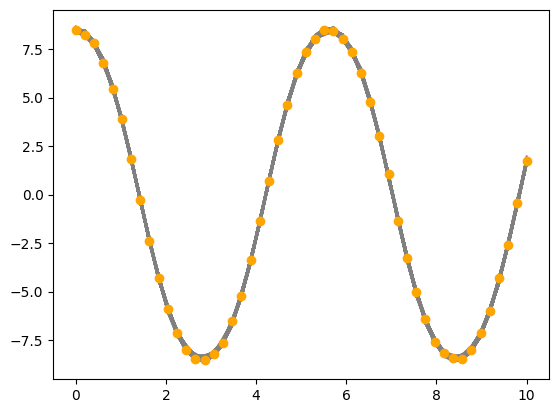

In [31]:
how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)

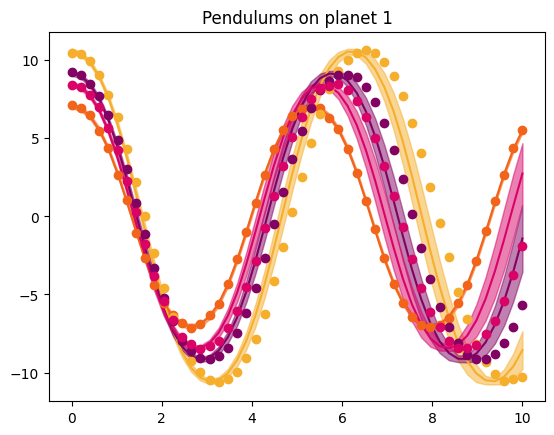

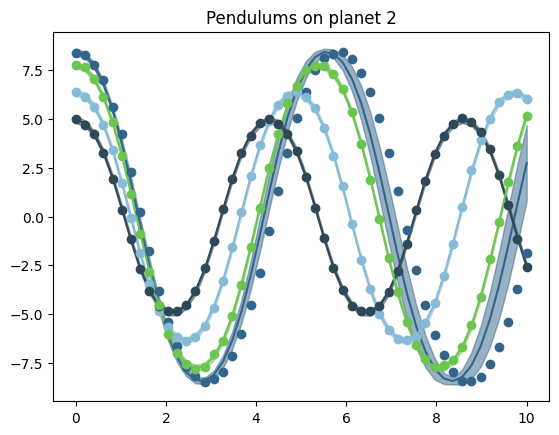

In [32]:
how_did_we_do_on_all_pendulums(df, posterior, 8, 2000)

In [ ]:
print(np.shape(posterior["L"][:,0]))
data = az.from_dict(
    posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
               "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
               "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
               "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
               },
    sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)

figure = corner.corner(data, divergences=True)#,
                       #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

(8000,)


In [48]:
# plot the posterior predictive samples
# get posterior predictive samples

planet_encoder = LabelEncoder()

planets = planet_encoder.fit_transform(df["planet_code"])
planets = jnp.array(planets)

pooled_posterior_predictive = numpyro.infer.Predictive(
    model=hierarchical_model, posterior_samples=posterior
)
rng_key, rng_subkey = random.split(rng_key)
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, planets)
# convert to arviz inference data object
pooled_idata = az.from_numpyro(
    posterior=pooled_mcmc, posterior_predictive=pooled_posterior_predictive_samples
)
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(
    data=pooled_idata,
    observed_rug=True,
    ax=ax,
)
ax.set(
    title="Pooled Model Posterior Predictive Check",
    xlabel="chips",
    ylabel="count",
)

TypeError: hierarchical_model() missing 2 required positional arguments: 'pendulum_code' and 'times'

In [ ]:
print(data_params)

In [ ]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1], color = '#436436')
plt.axhline(y = np.mean(df[df['planet_code'] == 1]['a_g']), color = '#8DAD68')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) - np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) + np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')

plt.ylabel('a_g')

plt.plot(mcmc.get_samples()['a_g'][:,0], color = '#ADB9E3')
plt.axhline(y = np.mean(df[df['planet_code'] == 0]['a_g']), color = '#A379C9')
plt.ylabel('a_g')
plt.show()
df

## Now run the inference for the unpooled (non-hierarchical) case

In [33]:
nuts_kernel_unpooled = NUTS(unpooled_model)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
inf_data_unpooled = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_unpooled)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]      10.130  1.506   7.442   13.712      0.193    0.138      51.0   
L[1]      12.495  3.979   6.048   17.362      1.985    1.521       4.0   
L[2]      13.830  2.605  10.348   18.029      1.291    0.988       4.0   
L[3]      12.775  2.409   9.571   16.664      1.192    0.912       4.0   
L[4]       8.929  1.667   6.676   11.628      0.824    0.631       4.0   
L[5]      11.407  7.009   5.833   24.403      3.486    2.668       4.0   
L[6]      10.931  2.066   8.182   14.306      1.023    0.783       4.0   
L[7]      11.919  2.242   8.935   15.585      1.111    0.850       4.0   
a_g[0]    14.184  2.107  10.354   19.149      0.270    0.194      51.0   
a_g[1]    14.897  2.797  11.180   19.373      1.388    1.062       4.0   
theta[0]   0.801  0.146   0.507    1.091      0.018    0.013      55.0   
theta[1]   0.701  0.266   0.213    1.051      0.131    0.100       5.0   
theta[2]   0.767  0.166   0.502    1.025      0.082    0.062       5.0   
theta[3]   0.765  0.163   0.508    1.026      0.080    0.061       5.0   
theta[4]   0.840  0.186   0.528    1.151      0.090    0.069       5.0   
theta[5]   0.581  0.346   0.012    0.976      0.172    0.131       4.0   
theta[6]   0.831  0.190   0.529    1.137      0.093    0.071       5.0   
theta[7]   0.840  0.187   0.552    1.163      0.092    0.070       5.0   
σ          1.047  1.112   0.061    2.845      0.555    0.425       5.0   

          ess_tail  r_hat  
L[0]          70.0   1.79  
L[1]          13.0   3.37  
L[2]          12.0   3.23  
L[3]          11.0   3.26  
L[4]          12.0   3.20  
L[5]          11.0   3.42  
L[6]          11.0   3.26  
L[7]          13.0   3.25  
a_g[0]        79.0   1.78  
a_g[1]        11.0   3.35  
theta[0]      82.0   1.74  
theta[1]      12.0   3.06  
theta[2]      14.0   3.02  
theta[3]      16.0   2.91  
theta[4]      18.0   2.64  
theta[5]      11.0   3.16  
theta[6]      14.0   2.92  
theta[7]      16.0   2.86  
σ             16.0   3.08

In [ ]:
data_unpooled = az.from_numpyro(mcmc_unpooled)
az.plot_trace(data_unpooled, compact=True, figsize=(15, 25), legend=True);

In [45]:
posterior_unpooled = mcmc_unpooled.get_samples()
posterior_unpooled

{'L': Array([[ 7.1843357, 12.175501 , 10.568163 , ..., 24.886055 ,  8.244404 ,
          8.943725 ],
        [ 7.4303856, 12.01254  , 10.602785 , ..., 24.891514 ,  8.21846  ,
          8.924379 ],
        [ 7.487418 , 12.015163 , 10.608858 , ..., 24.897732 ,  8.216957 ,
          8.895149 ],
        ...,
        [10.610572 , 17.664354 , 15.300516 , ...,  7.69695  , 12.083883 ,
         13.182642 ],
        [10.60467  , 17.664352 , 15.300507 , ...,  7.697136 , 12.083985 ,
         13.183027 ],
        [10.630962 , 17.665676 , 15.300299 , ...,  7.6958494, 12.082124 ,
         13.183056 ]], dtype=float32),
 'a_g': Array([[10.020947, 11.32017 ],
        [10.437369, 11.272108],
        [10.558584, 11.280863],
        ...,
        [14.83799 , 16.488531],
        [14.844001, 16.489271],
        [14.886745, 16.48999 ]], dtype=float32),
 'theta': Array([[1.1211114 , 1.0152164 , 0.9802664 , ..., 0.03861358, 1.1230736 ,
         1.2245504 ],
        [1.128377  , 1.0100145 , 0.9745588 , ..., 0.042

In [ ]:
how_did_we_do_on_individual_pendulums(df, posterior_unpooled, 8, 2000)

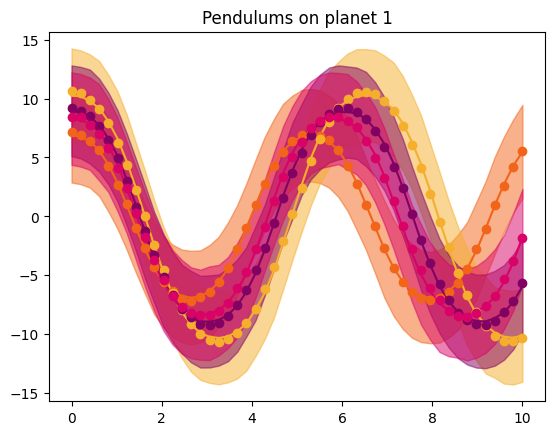

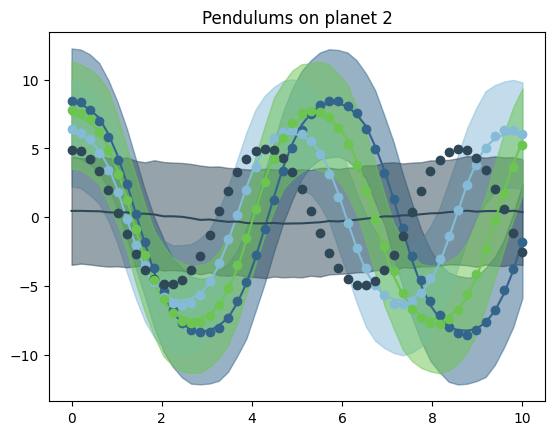

In [49]:
how_did_we_do_on_all_pendulums(df, posterior_unpooled, 8, 2000)
#how_did_we_do_on_all_pendulums(df, posterior, 8, 2000)

(8000,)


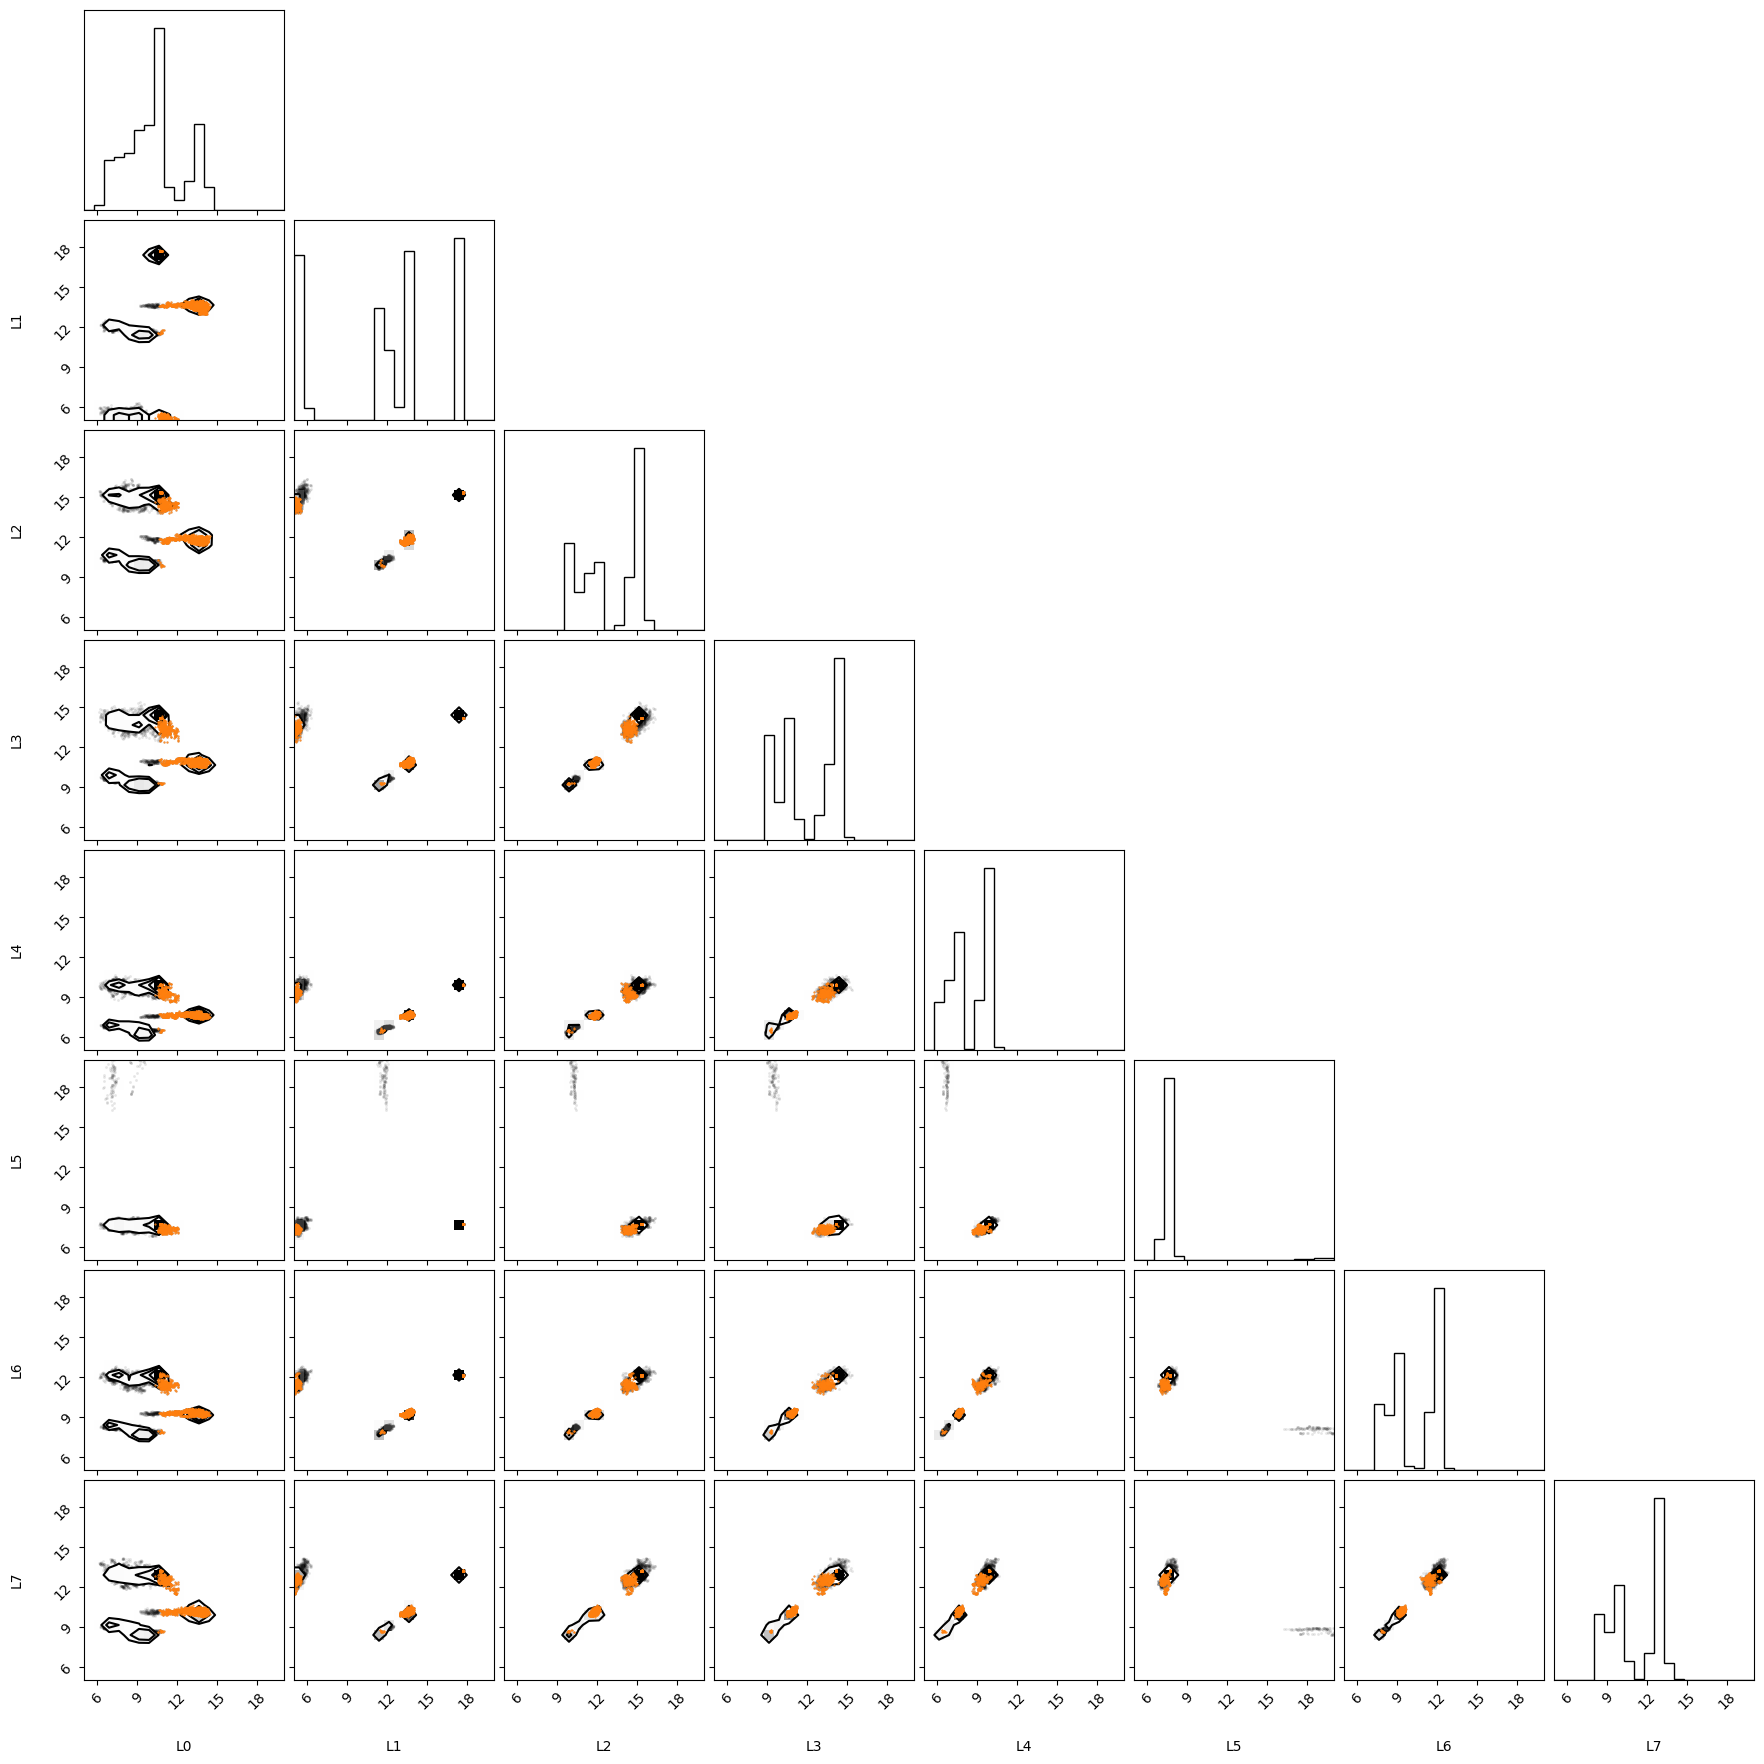

In [51]:
print(np.shape(posterior_unpooled["L"][:,0]))
data = az.from_dict(
    posterior={"L0": posterior_unpooled["L"][:,0], "L1": posterior_unpooled["L"][:,1],
               "L2": posterior_unpooled["L"][:,2], "L3": posterior_unpooled["L"][:,3],
               "L4": posterior_unpooled["L"][:,4], "L5": posterior_unpooled["L"][:,5],
               "L6": posterior_unpooled["L"][:,6], "L7": posterior_unpooled["L"][:,7],
               },
    sample_stats={"diverging": posterior_unpooled["a_g"][:,0] > 15.0},
)

figure = corner.corner(data, divergences=True,
                       range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

(8000,)


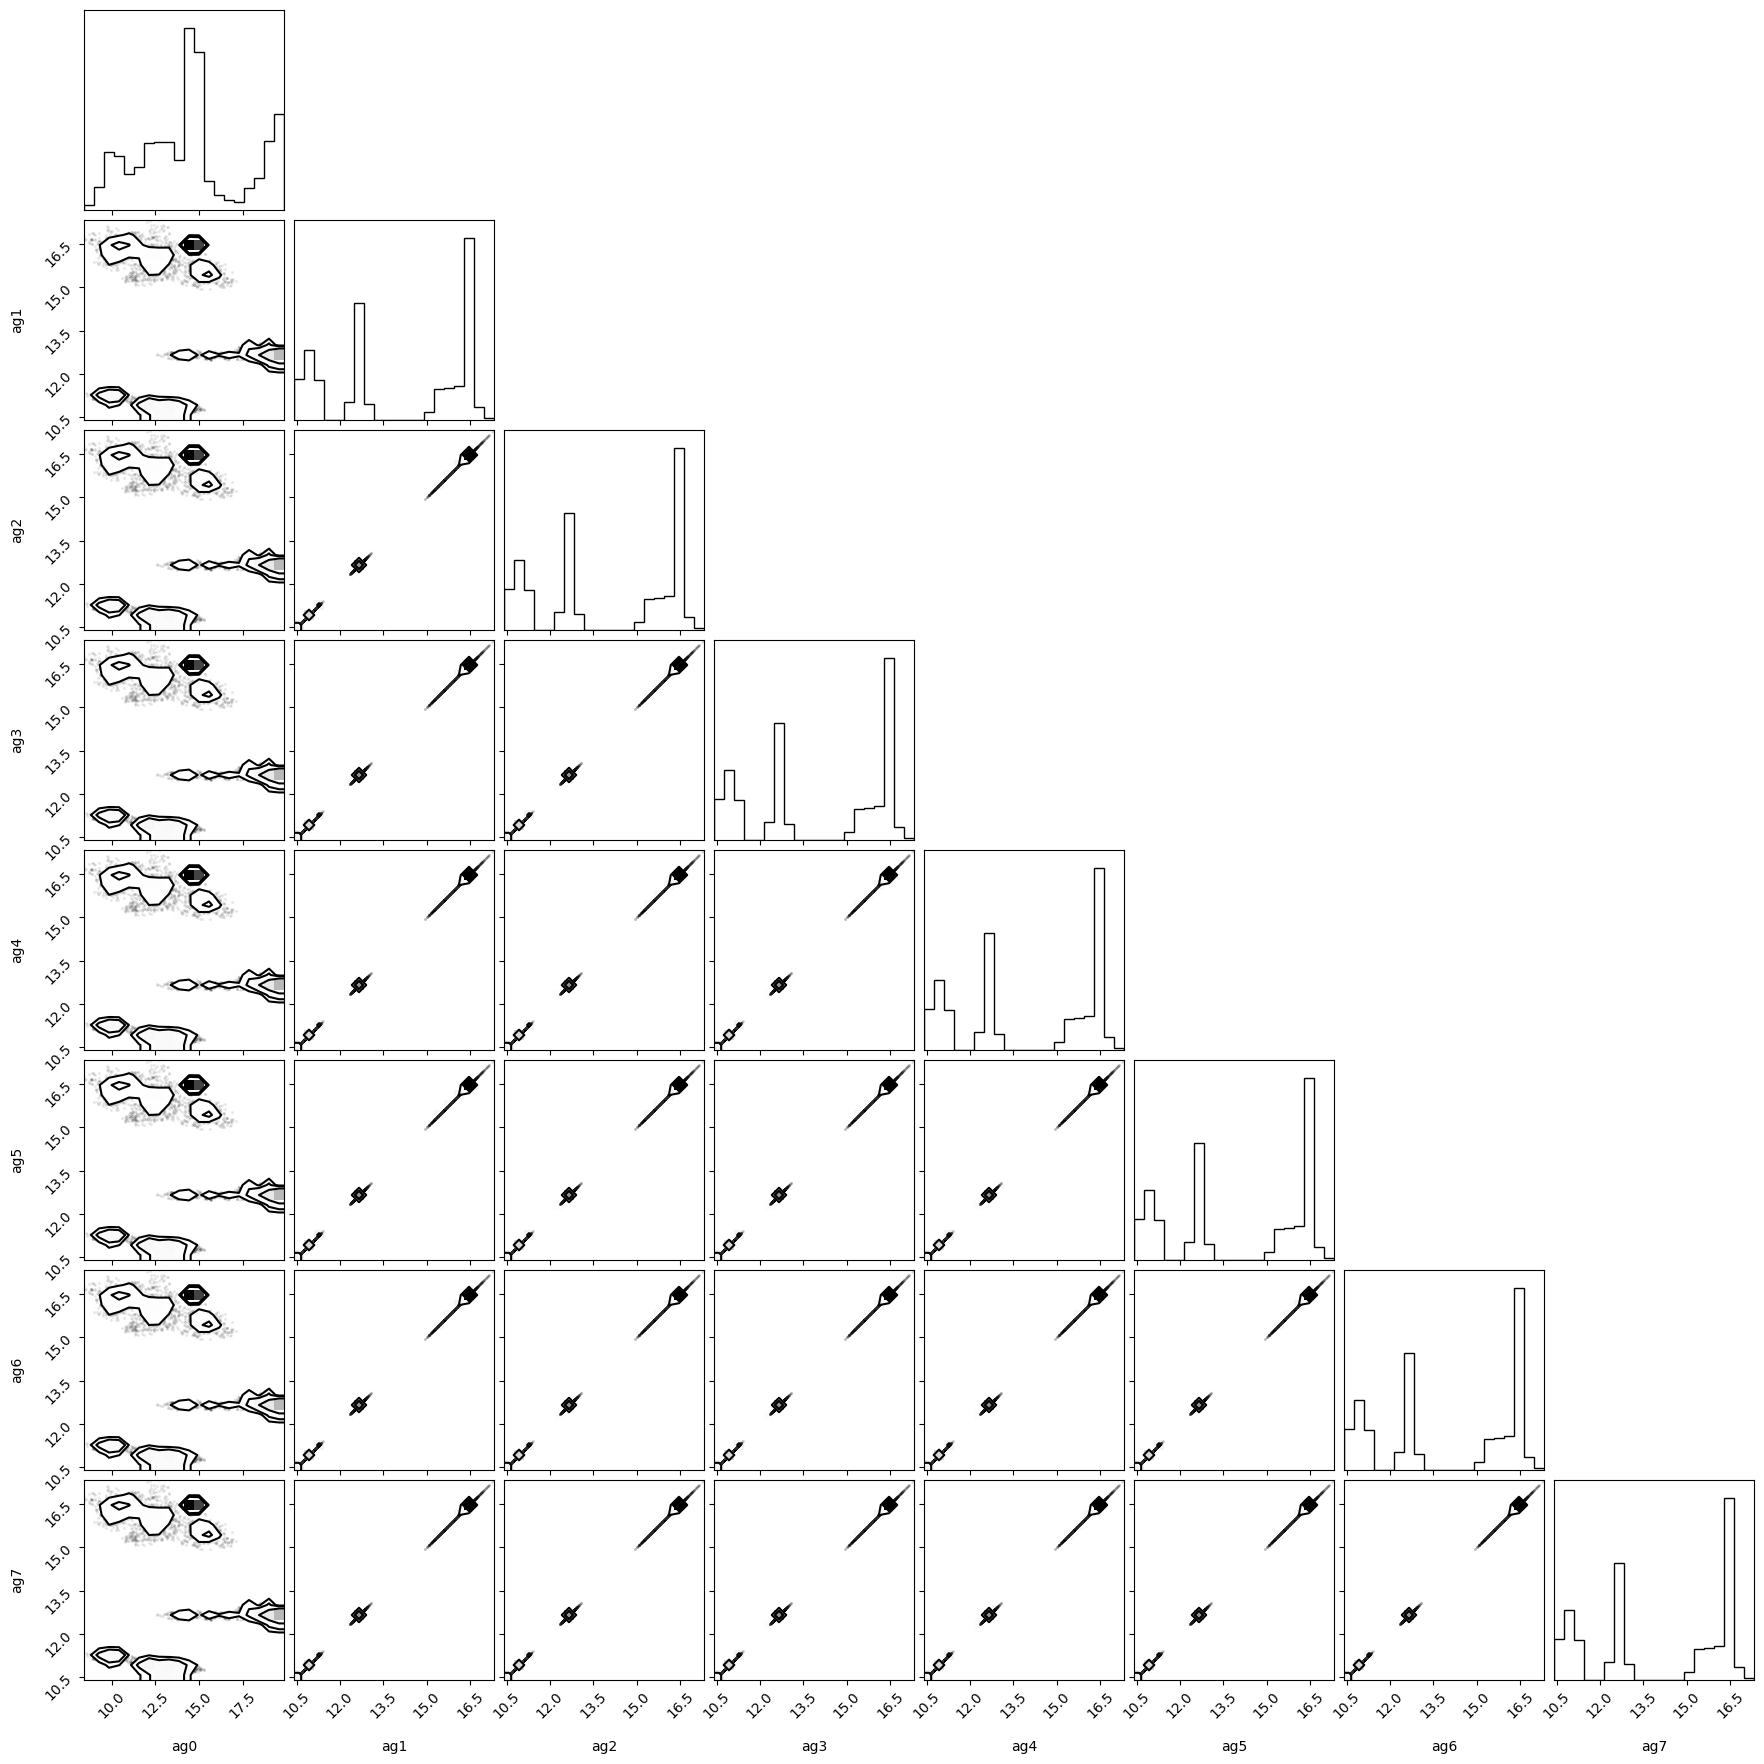

In [52]:

print(np.shape(posterior_unpooled["a_g"][:,0]))
data = az.from_dict(
    posterior={"ag0": posterior_unpooled["a_g"][:,0], "ag1": posterior_unpooled["a_g"][:,1],
               "ag2": posterior_unpooled["a_g"][:,2], "ag3": posterior_unpooled["a_g"][:,3],
               "ag4": posterior_unpooled["a_g"][:,4], "ag5": posterior_unpooled["a_g"][:,5],
               "ag6": posterior_unpooled["a_g"][:,6], "ag7": posterior_unpooled["a_g"][:,7],
               },
    sample_stats={"diverging": posterior_unpooled["a_g"][:,0] > 15.0},
)

figure = corner.corner(data)
                       #, divergences=True,
                       #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

In [ ]:
def pos_calculator_integer(L, theta, a_g, sigma, time):
    print('this is the cosine arg', np.sqrt(a_g / L), 'cosine of this', np.cos(np.sqrt(a_g / L)))
    print('this is the sine arg', theta * np.cos(np.sqrt(a_g / L)) * time, 'sine of this', np.sin(theta * np.cos(np.sqrt(a_g / L)) * time))
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma
    return pos

'''
theta_time = starting_angle_values * np.cos(
            np.sqrt(acceleration_values / pendulum_arm_length_values)
        )

        # Calculate x using the modified parameters and time
        return pendulum_arm_length_values * np.sin(theta_time * time)

'''
L = 10
theta = np.pi / 2
a_g = 10
sigma = 0.05
times = 0
print(pos_calculator_integer(L,theta,a_g,sigma,times))